# Object Detection API Demo

### Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
tf.enable_eager_execution()
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [2]:
import pathlib

Import the object detection module.

In [3]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

Patches:

In [4]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing the path.

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

## Loader

In [11]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = '../../../fine_tuned/saved_model'

  model = tf.compat.v2.saved_model.load(str(model_dir), None)

  return model

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [7]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '../../../annotations/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

For the sake of simplicity we will test on 2 images:

In [19]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('../../../../workspace/squirrel_detector/images/Squirrel')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('../../../../workspace/squirrel_detector/images/Squirrel/00599a4e08792ee1.jpg'),
 PosixPath('../../../../workspace/squirrel_detector/images/Squirrel/008ad3e3d1c16250.jpg'),
 PosixPath('../../../../workspace/squirrel_detector/images/Squirrel/00cf1b59a57da240.jpg'),
 PosixPath('../../../../workspace/squirrel_detector/images/Squirrel/00e105b4783d743f.jpg'),
 PosixPath('../../../../workspace/squirrel_detector/images/Squirrel/00e465d9d57512d5.jpg'),
 PosixPath('../../../../workspace/squirrel_detector/images/Squirrel/0178d836e72973b4.jpg'),
 PosixPath('../../../../workspace/squirrel_detector/images/Squirrel/01f85ffb6ee062f9.jpg'),
 PosixPath('../../../../workspace/squirrel_detector/images/Squirrel/02169221723e0886.jpg'),
 PosixPath('../../../../workspace/squirrel_detector/images/Squirrel/022a6508667c26a4.jpg'),
 PosixPath('../../../../workspace/squirrel_detector/images/Squirrel/0284bc96bfcd43c7.jpg'),
 PosixPath('../../../../workspace/squirrel_detector/images/Squirrel/02a83d8659c2

# Detection

Load an object detection model:

In [20]:
model_name = 'ssd_mobilenet_v2_coco_2018_03_29'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Check the model's input signature, it expects a batch of 3-color images of type uint8:

In [21]:
print(detection_model.signatures['serving_default'].inputs)

[<tf.Tensor 'image_tensor:0' shape=(?, ?, ?, 3) dtype=uint8>]


And returns several outputs:

In [22]:
detection_model.signatures['serving_default'].output_dtypes

{'raw_detection_scores': tf.float32,
 'detection_multiclass_scores': tf.float32,
 'detection_classes': tf.float32,
 'num_detections': tf.float32,
 'detection_boxes': tf.float32,
 'raw_detection_boxes': tf.float32,
 'detection_scores': tf.float32}

In [23]:
detection_model.signatures['serving_default'].output_shapes

{'raw_detection_scores': TensorShape([Dimension(None), Dimension(None), Dimension(2)]),
 'detection_multiclass_scores': TensorShape([Dimension(None), Dimension(100), Dimension(2)]),
 'detection_classes': TensorShape([Dimension(None), Dimension(100)]),
 'num_detections': TensorShape([Dimension(None)]),
 'detection_boxes': TensorShape([Dimension(None), Dimension(100), Dimension(4)]),
 'raw_detection_boxes': TensorShape([Dimension(None), Dimension(None), Dimension(4)]),
 'detection_scores': TensorShape([Dimension(None), Dimension(100)])}

Add a wrapper function to call the model, and cleanup the outputs:

In [24]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Run it on each test image and show the results:

In [25]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

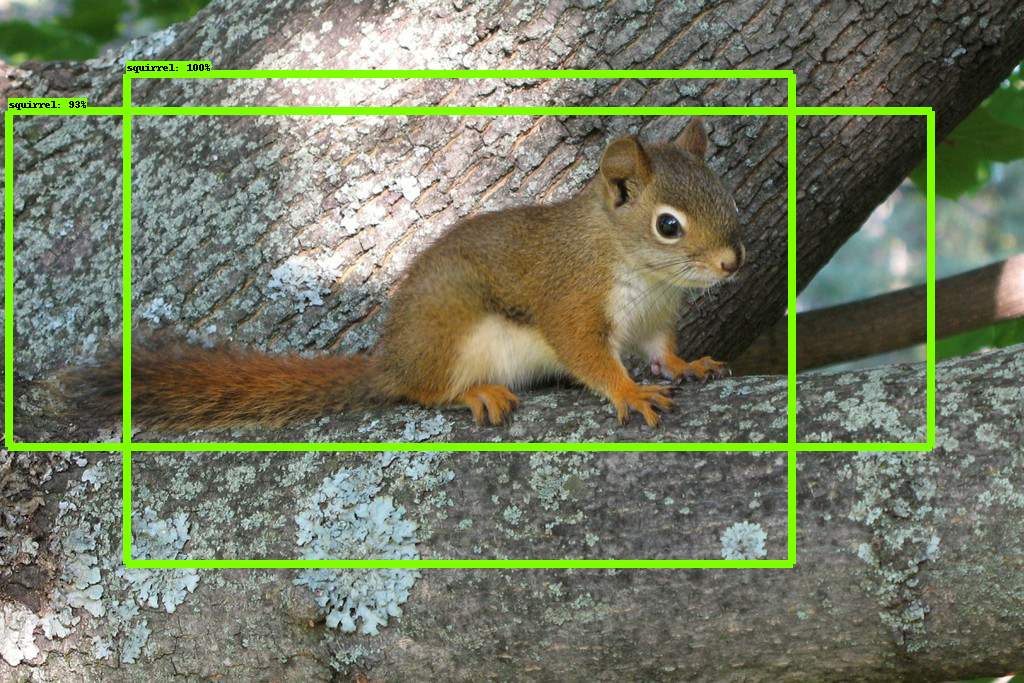

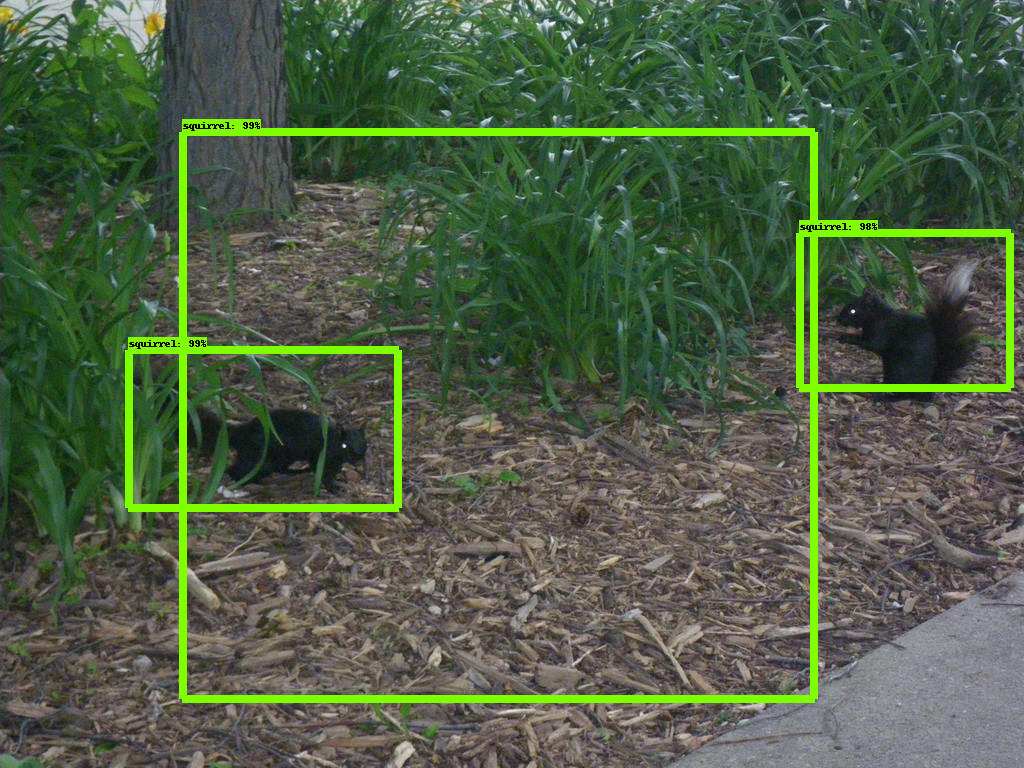

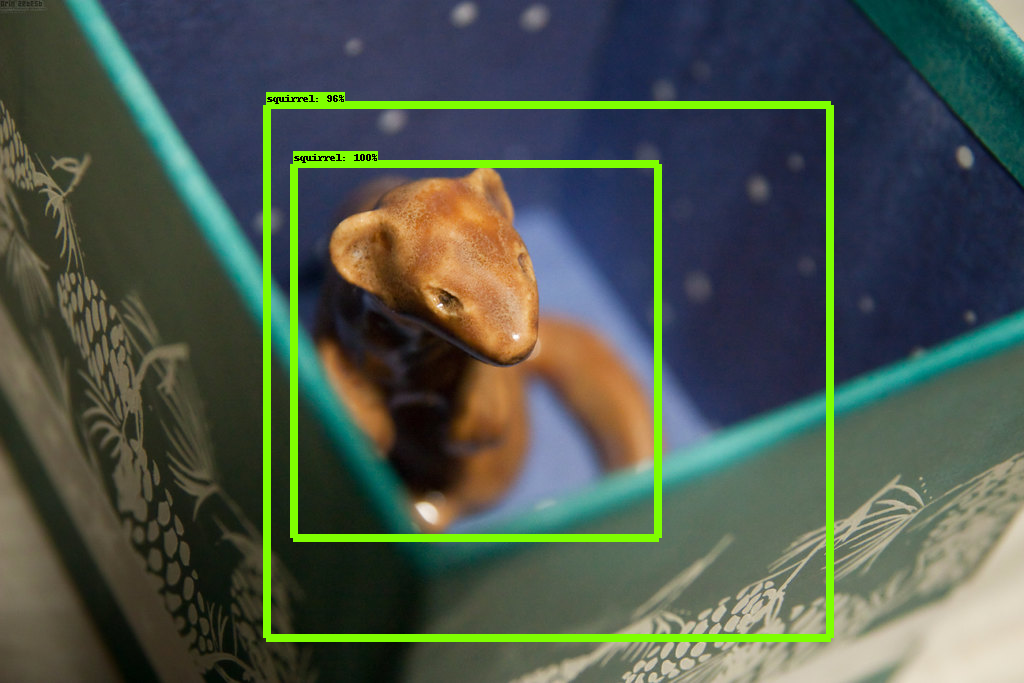

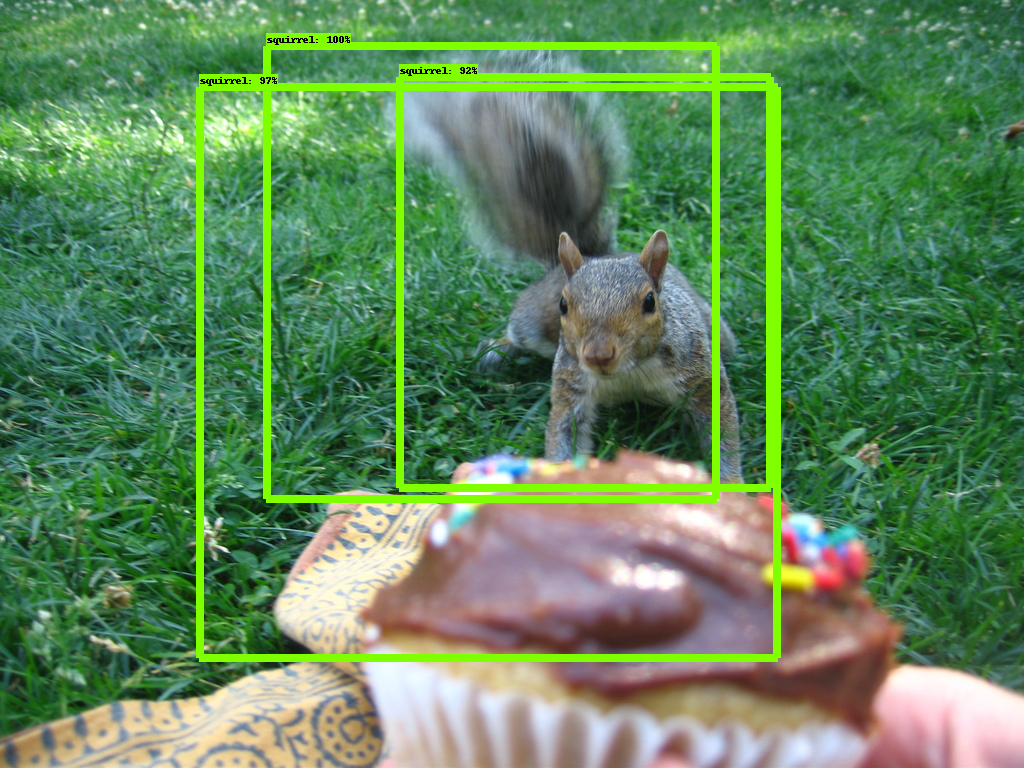

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  input must be 4-dimensional[1,774,1024]
	 [[node Preprocessor/map/while/ResizeImage/resize/ResizeBilinear (defined at /usr/lib/python3/dist-packages/tensorflow_core/python/framework/ops.py:1748) ]]
	 [[Preprocessor/map/while/Identity/_43]]
  (1) Invalid argument:  input must be 4-dimensional[1,774,1024]
	 [[node Preprocessor/map/while/ResizeImage/resize/ResizeBilinear (defined at /usr/lib/python3/dist-packages/tensorflow_core/python/framework/ops.py:1748) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_pruned_12769]

Function call stack:
pruned -> pruned


In [26]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)
